In [1]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)
import cv2
from pycocotools import mask
import pandas as pd
import json

In [2]:
!pwd

/mmdetection/demo


In [2]:
dataDir='..'
dataType='test_train_valid_combination'
# dataType = 'train'

annFile='{}/data/coco_datasets/datasets/scratch/annotations/{}.json'.format(dataDir,dataType)
# initialize COCO api for instance annotations
coco=COCO(annFile)


loading annotations into memory...
Done (t=3.39s)
creating index...
index created!


In [4]:
print(len(coco.anns), len(coco.imgs), len(coco.cats))

120119 23694 1


In [5]:
# display COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds())
print((cats))
nms=[cat['name'] for cat in cats]
print(nms)
print('COCO categories: \n{}\n'.format(' '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}'.format(' '.join(nms)))

[{'supercategory': 'Carparts', 'id': 0, 'name': 'scratch'}]
['scratch']
COCO categories: 
scratch

COCO supercategories: 
Carparts


## Plot annotation damages in images

In [6]:
# get all images containing given categories, select one at random
catIds = coco.getCatIds(catNms=['scratch']);
imgIds = coco.getImgIds(catIds=catIds );
imgIds = coco.getImgIds(imgIds = [2021])
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]
print(img)

{'id': 2021, 'license': 4, 'coco_url': 'coco.org', 'flickr_url': 'flickr.org', 'scalabel_url': 'https://s3.amazonaws.com/mc-imt/vehicle/2019Y7149/vehicle_additional_docs/21749/medium/15559750008971833159462424792505.jpg', 'width': 700, 'height': 525, 'file_name': 'https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7149_vehicle_additional_docs_21749_medium_15559750008971833159462424792505.jpg', 'date_captured': '2013-12-15 02:41:52'}


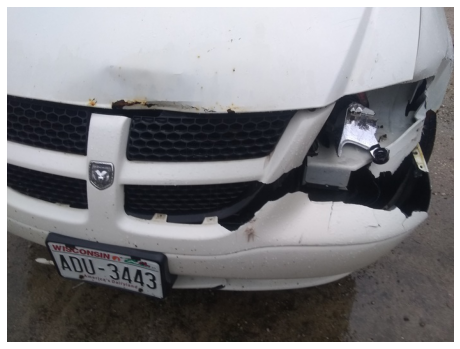

In [7]:
# load and display image
I = io.imread('%s/data/coco_datasets/datasets/scratch/images/%s'%(dataDir,img['file_name']))
# use url to load image
# I = io.imread(img['scalabel_url'])
plt.axis('off')
plt.imshow(I)
plt.show()

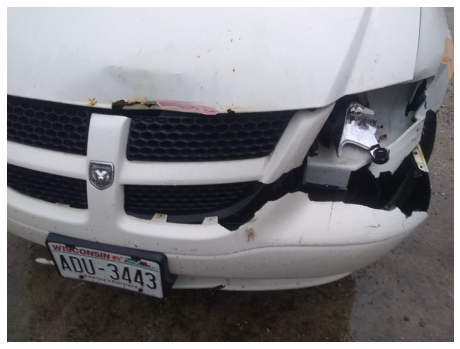

In [8]:
# load and display instance annotations
plt.imshow(I); plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

## Caculate features

In [9]:
coco.areas_seg = {}
coco.areas_bbox = {}
coco.mask_box_ratio = {}
coco.mask_image_ratio = {}
coco.box_image_ratio = {}

def compute_area(seg):
    seg = np.array(seg).reshape(-1,2).astype(np.int32)
    area = cv2.contourArea(seg)
    if area == 0:
        area = 1e-5
    return area

# for ann in coco.dataset['annotations']:
#     if ann['image_id'] == 5519:
#         print(compute_area(ann['segmentation']))    

for ann in coco.dataset['annotations']:
    coco.areas_seg[ann['id']] = compute_area(ann['segmentation'])
    coco.areas_bbox[ann['id']] = ann['bbox'][2] * ann['bbox'][3] if ann['bbox'][2] * ann['bbox'][3] > 0 else 1e-5
    
    for img in coco.dataset['images']:
        if ann['image_id'] == img['id']:
            img_area = img['width'] * img['height']
    
    coco.mask_box_ratio[ann['id']] = coco.areas_seg[ann['id']]/coco.areas_bbox[ann['id']]
    coco.mask_image_ratio[ann['id']] = coco.areas_seg[ann['id']]/img_area
    coco.box_image_ratio[ann['id']] = coco.areas_bbox[ann['id']]/img_area



In [11]:
print(coco.areas_seg[7341], coco.areas_bbox[7341])
print(len(coco.areas_seg), len(coco.areas_bbox))

801.0 1996.8467334607376
120119 120119


In [25]:
print(type(coco.mask_image_ratio))

<class 'dict'>


In [33]:
#save features
df_data = pd.DataFrame({'annotation_id': coco.areas_seg.keys(),'seg_area': coco.areas_seg.values(), 'bbox_area': coco.areas_bbox.values(), 
                        'mask_box_ratio': coco.mask_box_ratio.values(),'mask_image_ratio': coco.mask_image_ratio.values(),
                       'box_image_ratio': coco.box_image_ratio.values()})
df_data["area_bin"] = pd.cut(df_data["mask_image_ratio"],
                bins=[0, 5.000000000000013e-05, 0.2, df_data["seg_area"].max()],
                labels=["Small", "Medium", "Large"])

In [34]:
df_data

,annotation_id,seg_area,bbox_area,mask_box_ratio,mask_image_ratio,box_image_ratio,area_bin
0,48,5703.0,12117.412797,0.470645,0.011881,0.025245,Medium
1,90,1027.0,2808.439002,0.365684,0.002795,0.007642,Medium
2,95,4999.0,14342.456162,0.348546,0.021004,0.060262,Medium
3,96,1802.0,3446.836984,0.522798,0.007571,0.014483,Medium
4,97,816.0,2571.313626,0.317348,0.003429,0.010804,Medium
...,...,...,...,...,...,...,...
120114,354492,102.0,279.067502,0.365503,0.000328,0.000897,Medium
120115,354493,273.5,593.063799,0.461165,0.000879,0.001906,Medium
120116,354494,26.5,36.447170,0.727080,0.000085,0.000117,Medium
120117,354495,131.5,312.874319,0.420297,0.000423,0.001005,Medium


In [35]:
df_data.to_csv('statistical_charts/old_scratch_report.csv',index=False)

## Plot data

In [38]:
data = pd.read_csv('statistical_charts/old_scratch_report.csv')
print('data shape', data.shape)
data


data shape (120119, 7)


,annotation_id,seg_area,bbox_area,mask_box_ratio,mask_image_ratio,box_image_ratio,area_bin
0,48,5703.0,12117.412797,0.470645,0.011881,0.025245,Medium
1,90,1027.0,2808.439002,0.365684,0.002795,0.007642,Medium
2,95,4999.0,14342.456162,0.348546,0.021004,0.060262,Medium
3,96,1802.0,3446.836984,0.522798,0.007571,0.014483,Medium
4,97,816.0,2571.313626,0.317348,0.003429,0.010804,Medium
...,...,...,...,...,...,...,...
120114,354492,102.0,279.067502,0.365503,0.000328,0.000897,Medium
120115,354493,273.5,593.063799,0.461165,0.000879,0.001906,Medium
120116,354494,26.5,36.447170,0.727080,0.000085,0.000117,Medium
120117,354495,131.5,312.874319,0.420297,0.000423,0.001005,Medium


array([[<AxesSubplot:title={'center':'annotation_id'}>,
        <AxesSubplot:title={'center':'seg_area'}>],
       [<AxesSubplot:title={'center':'bbox_area'}>,
        <AxesSubplot:title={'center':'mask_box_ratio'}>],
       [<AxesSubplot:title={'center':'mask_image_ratio'}>,
        <AxesSubplot:title={'center':'box_image_ratio'}>]], dtype=object)

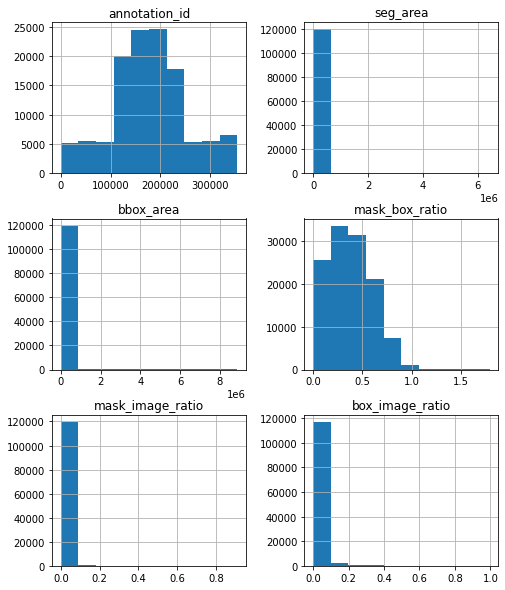

In [39]:
data.hist()

Text(0, 0.5, 'pixel2')

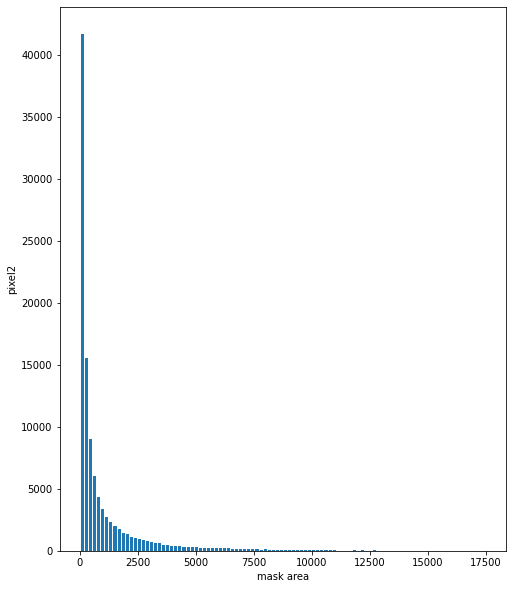

In [52]:
plt.hist(data[data.seg_area<1.75e4].seg_area, 100, edgecolor='w')
plt.xlabel('mask area')
plt.ylabel('pixel2')

Text(0, 0.5, 'pixel2')

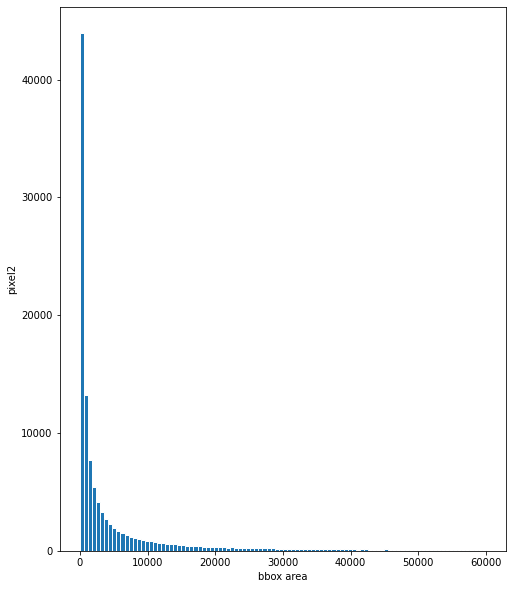

In [60]:
plt.hist(data[data.bbox_area<6e4].bbox_area, 100, edgecolor='w')
plt.xlabel('bbox area')
plt.ylabel('pixel2')

Text(0.5, 0, 'mask box ratio')

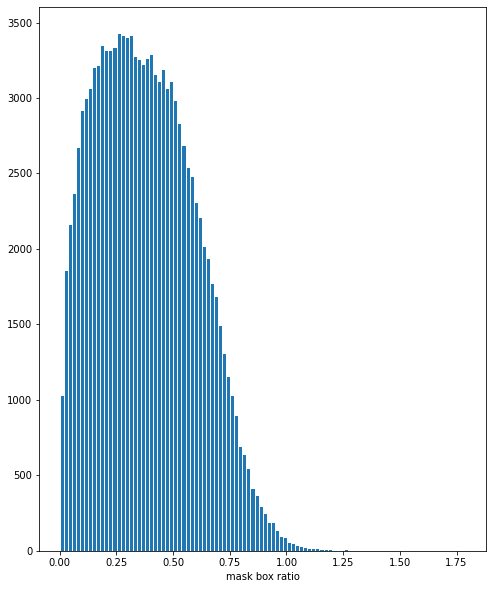

In [61]:
plt.hist(data.mask_box_ratio, 100, edgecolor='w')
plt.xlabel('mask box ratio')

Text(0.5, 0, 'mask image ratio')

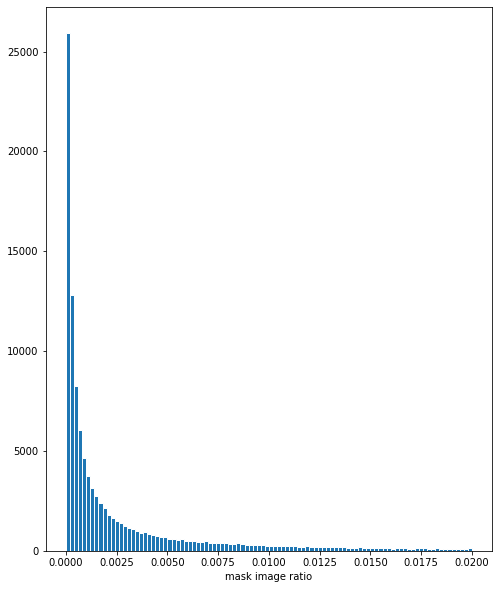

In [69]:
plt.hist(data[data.box_image_ratio<0.02].box_image_ratio, 100, edgecolor='w')
plt.xlabel('mask image ratio')

Text(0.5, 0, 'mask image ratio')

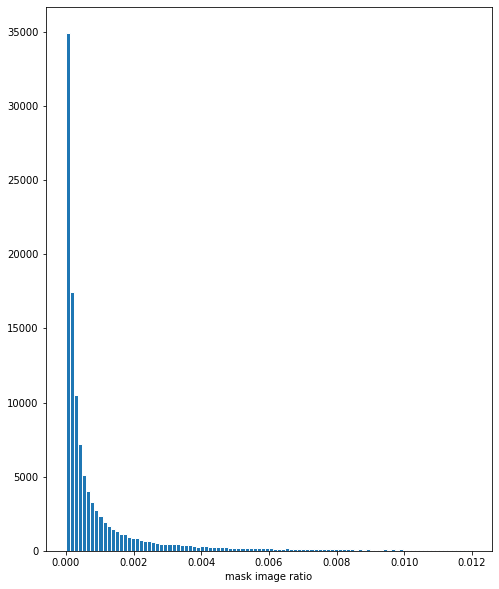

In [67]:
plt.hist(data[data.mask_image_ratio<0.012].mask_image_ratio, 100, edgecolor='w')
plt.xlabel('mask image ratio')

## try to clean data

In [3]:
data = pd.read_csv('statistical_charts/old_scratch_report.csv')
print('data shape', data.shape)
data

data shape (120119, 7)


,annotation_id,seg_area,bbox_area,mask_box_ratio,mask_image_ratio,box_image_ratio,area_bin
0,48,5703.0,12117.412797,0.470645,0.011881,0.025245,Medium
1,90,1027.0,2808.439002,0.365684,0.002795,0.007642,Medium
2,95,4999.0,14342.456162,0.348546,0.021004,0.060262,Medium
3,96,1802.0,3446.836984,0.522798,0.007571,0.014483,Medium
4,97,816.0,2571.313626,0.317348,0.003429,0.010804,Medium
...,...,...,...,...,...,...,...
120114,354492,102.0,279.067502,0.365503,0.000328,0.000897,Medium
120115,354493,273.5,593.063799,0.461165,0.000879,0.001906,Medium
120116,354494,26.5,36.447170,0.727080,0.000085,0.000117,Medium
120117,354495,131.5,312.874319,0.420297,0.000423,0.001005,Medium


In [11]:
data.describe()

,annotation_id,seg_area,bbox_area,mask_box_ratio,mask_image_ratio,box_image_ratio
count,120119.000000,1.201190e+05,1.201190e+05,1.201190e+05,1.201190e+05,1.201190e+05
mean,178240.281096,5.830605e+03,2.569750e+04,3.799435e-01,3.005265e-03,1.180090e-02
std,74958.224479,5.408023e+04,1.618425e+05,2.177523e-01,1.480443e-02,4.171632e-02
min,48.000000,1.000000e-05,1.000000e-05,3.953929e-10,8.201583e-13,8.201583e-13
25%,133188.500000,1.020000e+02,2.769216e+02,2.032933e-01,9.684245e-05,2.527437e-04
50%,176653.000000,3.920000e+02,1.392622e+03,3.638854e-01,3.219181e-04,1.124773e-03
75%,219937.500000,1.790500e+03,7.649833e+03,5.357250e-01,1.235156e-03,5.642258e-03
max,354496.000000,6.425146e+06,8.865597e+06,1.789893e+00,9.081657e-01,9.948913e-01


## clean tiny and huge scratch based on segmentation area 

mean  5830.605374673033     std  54080.22882699124


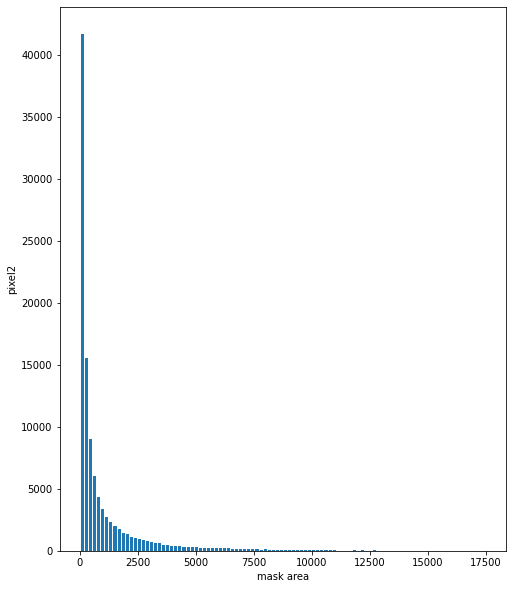

In [12]:
plt.hist(data[data.seg_area<1.75e4].seg_area, 100, edgecolor='w')
plt.xlabel('mask area')
plt.ylabel('pixel2')

seg_area_mean = data.seg_area.mean()
seg_area_std = data.seg_area.std()
print('mean ', seg_area_mean, '    std ', seg_area_std)

upper_limit 59910.83420166427
data frame shape (76238, 7)  <=>  remove 43881 outliers
percentage of outliers: 36.531 %


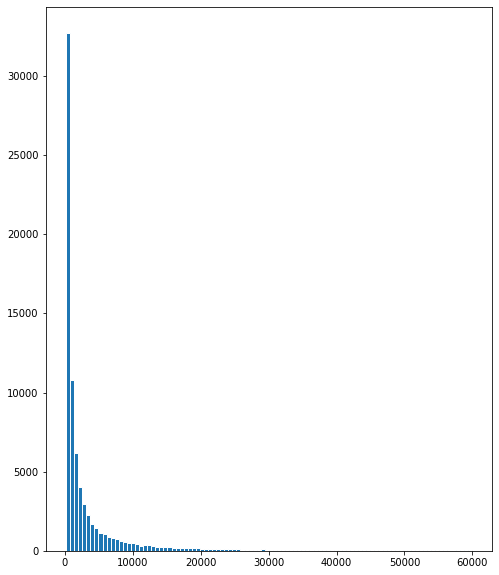

In [30]:
# remove area_seg > mean + 0.5 * std. After visualizing the mask of one of the filtered outliers, 
#I saw that the damage with area: 76507.0 is not much large. so I'm gonna move z-score far away toward the right.
#so I will remove area_seg > mean + 2*std, then visualize to see if the coefficient of 2 is fine?

upper_limit = seg_area_mean + 1*seg_area_std
lower_limit = 176
print('upper_limit', upper_limit)
data_removed_seg_outliers = data[(data.seg_area<upper_limit)&(data.seg_area>lower_limit)]
print('data frame shape', data_removed_seg_outliers.shape, ' <=>  remove {} outliers'.format(data.shape[0]-data_removed_seg_outliers.shape[0]))
n, bins, _ = plt.hist(data_removed_seg_outliers.seg_area, 100, edgecolor='w')

print('percentage of outliers: {:.3f} %'.format(100*(1-data_removed_seg_outliers.shape[0]/data.shape[0])))

### draw a random filtered outlier above upper limit

In [16]:
upper_seg_area_outlier = data[(data.seg_area>=upper_limit)]
print('number of upper outliers', upper_seg_area_outlier.shape[0])

number of upper outliers 921


annoId 215681      area: 306425.5
(56, 1, 2)
<class 'list'>


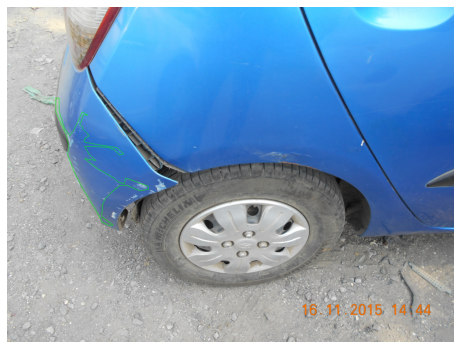

In [31]:
sample = temporary_seg_area_outlier.sample(n=1)
# print(sample)
annoId = sample.annotation_id.iloc[0]
seg_area = sample.seg_area.iloc[0]
print('annoId', annoId, '     area:', seg_area)
#get image id
for ann in coco.anns.values():
    if ann['id'] == annoId:
        imgId = ann['image_id']
        seg = ann['segmentation']
        break
#get image name
for img in coco.imgs.values():
    if img['id'] == imgId:
        image = img
        img_name = img['file_name']
        break

I = io.imread('%s/data/coco_datasets/datasets/scratch/images/%s'%(dataDir,img_name))
plt.axis('off')
plt.imshow(I)
seg = np.array(seg).reshape(-1,1,2)
print((seg.shape))
print(type([seg]))

#get and contour from the segmentation
shape = I.copy()
cv2.drawContours(shape, [seg.astype(int)], -1, (0,255,0), 3)
plt.imshow(shape)

### conclusion: filtering tiny and huge scratch image based on damage area is irrational because the images are not the same size. so we need to filter outliers based on damage_area/image_area ration as below.

## clean tiny and huge scratches based on segmentation area/image area ratio

ratio mean  0.0030052651143048265     std  0.01480443435551977
ratio max  0.9081656901041668      ratio min  8.201583102376754e-13


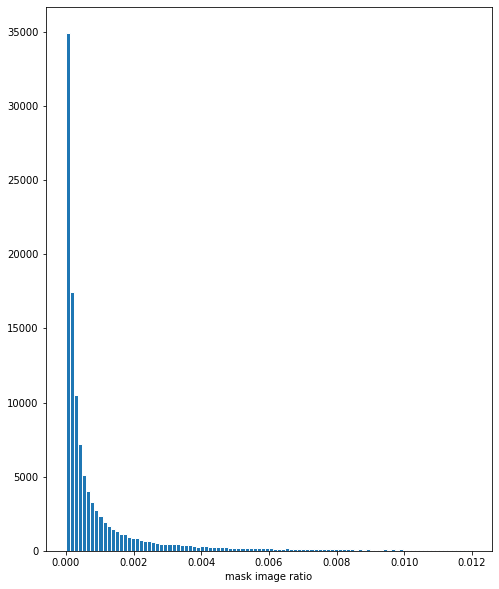

In [84]:
plt.hist(data[data.mask_image_ratio<0.012].mask_image_ratio, 100, edgecolor='w')
plt.xlabel('mask image ratio')

ratio_mean = data.mask_image_ratio.mean()
ratio_std = data.mask_image_ratio.std()
ratio_min = data.mask_image_ratio.min()
ratio_max = data.mask_image_ratio.max()
print('ratio mean ', ratio_mean, '    std ', ratio_std)
print('ratio max ', ratio_max, '     ratio min ', ratio_min)

### define filtering coefficients and save outlier data to a new data frame

In [85]:
#define lower, upper filtering coefficients
#these coefficients need to be iteratively adjusted to be fit well to specificity of the data

lower_coefficient = (ratio_mean - 0.00005)/ratio_std
upper_coefficient = (0.2- ratio_mean)/ratio_std
print(lower_coefficient, upper_coefficient)

0.1996202653431989 13.306468194257388


In [86]:
# define upper and lower limit 
upper_limit = ratio_mean + upper_coefficient*ratio_std
lower_limit = ratio_mean - lower_coefficient*ratio_std
print('upper_limit', upper_limit)
print('lower_limit', lower_limit)

#save outlier data in order to visualize, then investigate and adjust filtering coefficients
data_remove_outliers = data[(data.mask_image_ratio<lower_limit) | (data.mask_image_ratio>upper_limit)]
under_lower_ratio_outlier = data[(data.mask_image_ratio<=lower_limit)]
above_upper_ratio_outlier = data[(data.mask_image_ratio>=upper_limit)]


print('shape of outliers data frame: ', data_remove_outliers.shape, '<=>  remove {} outliers'.format(data_remove_outliers.shape[0]))
print('precentage of total outliers: {:.3f} %'.format((data_remove_outliers.shape[0]/data.shape[0])*100))
print('precentage of tiny outliers: {:.3f} %'.format((under_lower_ratio_outlier.shape[0]/data.shape[0])*100))
print('precentage of huge outliers: {:.3f} %'.format((above_upper_ratio_outlier.shape[0]/data.shape[0])*100))

# n, bins, _ = plt.hist(data_remove_outliers.mask_image_ratio, 100, edgecolor='w')


upper_limit 0.2
lower_limit 5.000000000000013e-05
shape of outliers data frame:  (17368, 7) <=>  remove 17368 outliers
precentage of total outliers: 14.459 %
precentage of tiny outliers: 14.352 %
precentage of huge outliers: 0.107 %


In [87]:
print('number of under outliers', under_lower_ratio_outlier.shape[0])

print('number of above outliers', above_upper_ratio_outlier.shape[0])

number of under outliers 17239
number of above outliers 129


### draw a random filtered outlier under lower limit

annoId 338074      area: 20.0     ratio 2.5431315104166668e-05
(4, 1, 2)
<class 'list'>


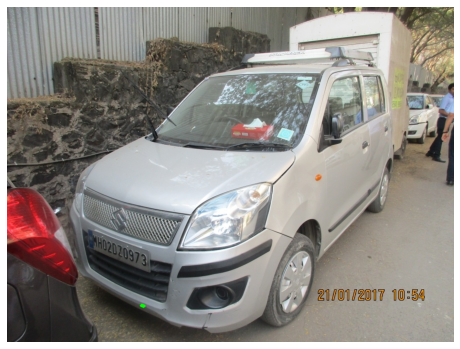

In [89]:
under_lower_ratio_outlier = data[(data.mask_image_ratio<=lower_limit)]

sample = under_lower_ratio_outlier.sample(n=1)

# sample = data[(data.mask_image_ratio>=0.9)]
# print(sample)

# print(sample)
annoId = sample.annotation_id.iloc[0]
seg_area = sample.seg_area.iloc[0]
seg_image_rati0 = sample.mask_image_ratio.iloc[0]

print('annoId', annoId, '     area:', seg_area, '    ratio', seg_image_rati0)
#get image id
for ann in coco.anns.values():
    if ann['id'] == annoId:
        imgId = ann['image_id']
        seg = ann['segmentation']
        break
#get image name
for img in coco.imgs.values():
    if img['id'] == imgId:
        image = img
        img_name = img['file_name']
        break

I = io.imread('%s/data/coco_datasets/datasets/scratch/images/%s'%(dataDir,img_name))
plt.axis('off')
plt.imshow(I)
seg = np.array(seg).reshape(-1,1,2)
print((seg.shape))
print(type([seg]))

#get and contour from the segmentation
shape = I.copy()
cv2.drawContours(shape, [seg.astype(int)], -1, (0,255,0), 3)
plt.imshow(shape)

### draw a random filtered outlier above upper limit

annoId 7204      area: 62380.5     ratio 0.2261802030456852
(144, 1, 2)
<class 'list'>


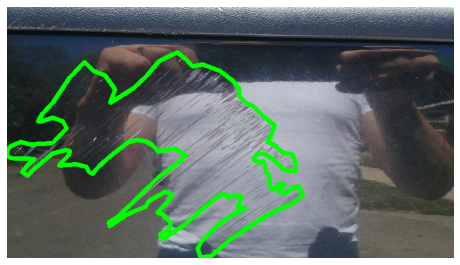

In [90]:
above_upper_ratio_outlier = data[(data.mask_image_ratio>=upper_limit)]
sample = above_upper_ratio_outlier.sample(n=1)

# sample = data[(data.mask_image_ratio>=0.9)]
# print(sample)

# print(sample)
annoId = sample.annotation_id.iloc[0]
seg_area = sample.seg_area.iloc[0]
seg_image_rati0 = sample.mask_image_ratio.iloc[0]

print('annoId', annoId, '     area:', seg_area, '    ratio', seg_image_rati0)
#get image id
for ann in coco.anns.values():
    if ann['id'] == annoId:
        imgId = ann['image_id']
        seg = ann['segmentation']
        break
#get image name
for img in coco.imgs.values():
    if img['id'] == imgId:
        image = img
        img_name = img['file_name']
        break

I = io.imread('%s/data/coco_datasets/datasets/scratch/images/%s'%(dataDir,img_name))
plt.axis('off')
plt.imshow(I)
seg = np.array(seg).reshape(-1,1,2)
print((seg.shape))
print(type([seg]))

#get and contour from the segmentation
shape = I.copy()
cv2.drawContours(shape, [seg.astype(int)], -1, (0,255,0), 5)
plt.imshow(shape)

## clean tiny and huge scratches based on both segmentation's area and its area/image area ratio

In [4]:
json_path='../data/coco_datasets/datasets/scratch/annotations/test_car.json'
car_mask_data = json.load(open(json_path))

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

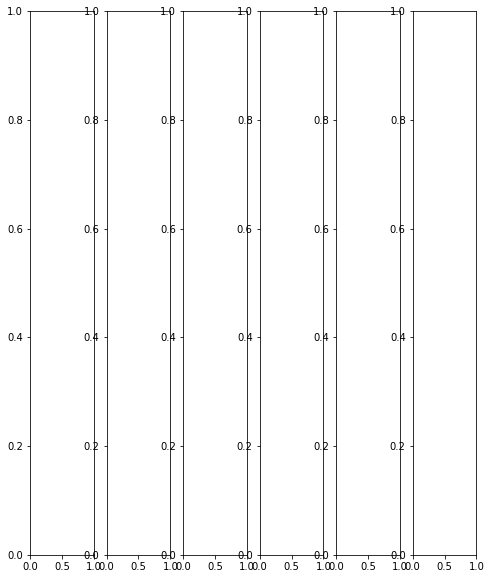

In [11]:
no_demo_images = 5
fig, axes = plt.subplots(1,6)
for i,img in enumerate(car_mask_data['images'][:6]):
    img_name = img['file_name']
    img = io.imread('%s/data/coco_datasets/datasets/scratch/images/%s'%(dataDir,img_name))
    axes[0,i].imshow(img)
#     plt.imshow(img)